In [1]:
import pybaseball as pyb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import seaborn as sns

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Swing Probability

오타니 쇼헤이 선수는 2021 시즌에 엄청난 성적을 거두었다. 오타니 선수는 언제 스윙했을까? 오타니 선수의 타자로써의 데이터를 Support Vector Machine에 학습시켜 스윙에 대한 예측 분석을 해보았다.   
   
타자가 스윙을 할지 말지를 결정하는 요소를 독립 변수(X)로 사용하였다. 독립 변수는 다음과 같다.
- 투구 위치 (plate_x, plate_z)  
- 투구 속도 (release_speed)   
- 구종 (수직/수평 무브먼트, pfx_x, pfx_z)   
- 카운트 (balls, strikes)  
- 우투수, 좌투수 (p_throws)
   
위의 독립 변수들로 오타니의 스윙 여부(y, 종속 변수)를 예측하는 SVM 모델을 생성하였다. 오타니의 21시즌 타자 데이터 중 일부를 학습 데이터로 활용하여 모델을 학습시켰고, 나머지 데이터로 테스트하여 성능을 검증하였다.
   
만들어진 SVM으로 오타니의 스윙 확률을 계산하고 시각화하였다. 직전 구종이 A였고, B-C 카운트 상황에서 투수가 D구종을 던졌을때, 오타니가 스윙을 할지 말지에 대한 확률 계산이다. 오타니의 예상 스윙은 21시즌 MLB에서 던져진 모든 공에 대해 계산하였고, 실제 오타니가 스윙한 데이터와 시각화를 통해 비교하였다.

- **1. [Importing Data](#import-data)**
    - Pybaseball 라이브러리를 통해 21시즌 MLB Statcast 데이터 중 오타니 쇼헤이에 대한 데이터를 추출하였다.
    - 오타니의 타석 데이터 중 예측에 사용할 독립변수(['plate_x', 'plate_z', 'release_speed', 'pfx_x', 'pfx_z', 'strikes', 'balls', 'pitch_name', 'previous_pitch', 'swing'])와 종속변수('Swing')를 새로운 데이터프레임으로 만들었다.
    
   
- **2. [Missing Data](#missing-data)**
    - Missing Data를 확인하고 이를 제거하였다.
       

- **3. [Formatting the Data for Support Vector Machines](#format-the-data)**
    - 새로 만든 데이터 프레임을 독립변수(X)와 종속변수(y)로 나누었다.
    - X와 y를 각각 모델을 학습시키는데 사용할 Train Data와 성능 검증하는데 사용할 Test Data로 분류하였다.
    - 범위와 수치가 제각각인 독립변수들을 같은 scale로 표준화하였다. 
    
          
- **4. [Building & Optimizing Support Vector Machine](#build-svm)**
    - Train Data로 SVM 모델을 학습시켰고, 파라미터들을 CrossValidation 방식으로 최적화하였다.
    - Test Data로 최적화된 모델을 검증하였다.
    - Confusion Matrix로 모델 예측 결과를 시각화하였고, 예측 정확도를 계산하였다.
       
   
- **6. [Swing Probability Visualization](#swing-prob)**
    - 주어진 조건에 대한 오타니 쇼헤이의 스윙 확률을 SVM으로 계산하였다.
    -  MLB에서 던져진 모든 공에 대해 계산하여 스트라이크 존에 시각화하였고, 실제 오타니가 스윙한 데이터와 비교하였다.

----

# Data Preparation

In [2]:
# 21시즌 mlb 데이터
mlb_21 = pyb.statcast('2021-04-01', '2021-10-03')

This is a large query, it may take a moment to complete


100%|██████████| 186/186 [03:13<00:00,  1.04s/it]


In [3]:
# 오타니 쇼헤이의 id
pyb.playerid_lookup('ohtani', 'shohei')

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,ohtani,shohei,660271,ohtas001,ohtansh01,19755,2018.0,2021.0


In [4]:
ohtani = mlb_21[mlb_21['batter']==660271]

스윙 여부를 알려주는 'Swing' 열을 만들고, 스윙을 했다면 1, 하지 않았다면 0을 대입한다. 스윙 여부(종속 변수)와 타자가 스윙을 결정하는 요소들(독립 변수)을 추출해 새로운 데이터 프레임을 만든다.

In [5]:
ohtani.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
1539,FF,2021-10-03,94.7,2.23,6.18,"Doolittle, Sean",660271,448281,strikeout,swinging_strike,<NA>,<NA>,<NA>,<NA>,12,Shohei Ohtani strikes out swinging.,R,L,L,SEA,LAA,S,2,NaN,1,2,2021,0.37,1.60,0.02,4.03,<NA>,<NA>,<NA>,2,7,Top,NaN,NaN,<NA>,<NA>,663728,<NA>,<NA>,-6.516817,-137.779057,-3.466723,6.188919,30.788268,-11.258349,3.55,1.63,<NA>,NaN,<NA>,93.9,2258,5.8,632237,448281,663728,664034,647351,572122,641487,641584,672284,571745,54.66,NaN,NaN,0.0,1,0,0,<NA>,66,4,4-Seam Fastball,3,7,7,3,7,3,7,3,Infield shift,Standard,165,0.003,-0.073
1629,CU,2021-10-03,81.7,2.17,6.01,"Doolittle, Sean",660271,448281,NaN,ball,<NA>,<NA>,<NA>,<NA>,13,Shohei Ohtani strikes out swinging.,R,L,L,SEA,LAA,B,<NA>,NaN,0,2,2021,-0.39,0.30,-1.31,2.01,<NA>,<NA>,<NA>,2,7,Top,NaN,NaN,<NA>,<NA>,663728,<NA>,<NA>,-7.068337,-118.792917,-3.015600,-2.386414,21.647060,-29.003861,3.42,1.63,<NA>,NaN,<NA>,81.5,2322,6.1,632237,448281,663728,664034,647351,572122,641487,641584,672284,571745,54.40,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,66,3,Curveball,3,7,7,3,7,3,7,3,Infield shift,Standard,253,0.000,0.011
1717,SL,2021-10-03,82.9,2.22,6.06,"Doolittle, Sean",660271,448281,NaN,called_strike,<NA>,<NA>,<NA>,<NA>,8,Shohei Ohtani strikes out swinging.,R,L,L,SEA,LAA,S,<NA>,NaN,0,1,2021,-0.44,0.27,-0.12,2.00,<NA>,<NA>,<NA>,2,7,Top,NaN,NaN,<NA>,<NA>,663728,<NA>,<NA>,-4.444459,-120.720699,-3.351161,-3.532491,22.352674,-29.141524,3.52,1.63,<NA>,NaN,<NA>,82.6,2247,5.9,632237,448281,663728,664034,647351,572122,641487,641584,672284,571745,54.59,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,66,2,Slider,3,7,7,3,7,3,7,3,Infield shift,Standard,243,0.000,-0.024
1762,FF,2021-10-03,94.0,1.80,6.18,"Doolittle, Sean",660271,448281,NaN,called_strike,<NA>,<NA>,<NA>,<NA>,8,Shohei Ohtani strikes out swinging.,R,L,L,SEA,LAA,S,<NA>,NaN,0,0,2021,0.36,1.61,-0.25,1.55,<NA>,<NA>,<NA>,2,7,Top,NaN,NaN,<NA>,<NA>,663728,<NA>,<NA>,-6.072494,-136.515340,-9.795329,5.883892,30.029616,-10.084807,3.47,1.63,<NA>,NaN,<NA>,93.6,2165,6.2,632237,448281,663728,664034,647351,572122,641487,641584,672284,571745,54.32,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,66,1,4-Seam Fastball,3,7,7,3,7,3,7,3,Infield shift,Standard,167,0.000,-0.018
3237,FF,2021-10-03,95.2,0.29,5.95,"Misiewicz, Anthony",660271,664948,strikeout,called_strike,<NA>,<NA>,<NA>,<NA>,11,Shohei Ohtani called out on strikes.,R,L,L,SEA,LAA,S,2,NaN,2,2,2021,0.57,1.35,-1.00,3.23,<NA>,<NA>,<NA>,1,4,Top,NaN,NaN,<NA>,<NA>,663728,<NA>,<NA>,-4.631986,-138.629276,-4.510426,8.405125,30.494569,-13.951210,3.51,1.61,<NA>,NaN,<NA>,94.7,2007,5.9,632237,664948,663728,664034,647351,572122,641487,664238,672284,571745,54.57,NaN,NaN,0.0,1,0,0,<NA>,34,5,4-Seam Fastball,2,4,4,2,4,2,4,2,Infield shift,Standard,145,0.012,-0.142


In [6]:
# ['Swing']열 생성
swing = ['hit_into_play', 'foul', 'swinging_strike', 'foul_tip', 'swinging_strike_blocked']
ohtani['swing'] = np.where(ohtani['description'].isin(swing),1,0)

# 학습에 사용할 데이터프레임
data = ohtani[['plate_x', 'plate_z', 'release_speed', 'pfx_x', 'pfx_z', 'strikes', 'balls', 'pitch_name', 'p_throws', 'swing']]

----

# Missing Data

In [10]:
# null 데이터 검색
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2586 entries, 1539 to 3371
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   plate_x        2586 non-null   float64
 1   plate_z        2586 non-null   float64
 2   release_speed  2586 non-null   float64
 3   pfx_x          2586 non-null   float64
 4   pfx_z          2586 non-null   float64
 5   strikes        2586 non-null   Int64  
 6   balls          2586 non-null   Int64  
 7   pitch_name     2586 non-null   object 
 8   p_throws       2586 non-null   object 
 9   swing          2586 non-null   int32  
dtypes: Int64(2), float64(5), int32(1), object(2)
memory usage: 217.2+ KB


총 2594개의 데이터 중 [plate_x]부터 [pfx_z]까지 2586이 non-null이었다. 이는 8개의 null 데이터가 포함되어 있다는 것을 의미한다.

In [8]:
# null data 확인
data[data['plate_x'].isnull()]

,plate_x,plate_z,release_speed,pfx_x,pfx_z,strikes,balls,pitch_name,p_throws,swing
2020,NaN,NaN,NaN,NaN,NaN,1,1,NaN,R,0
3156,NaN,NaN,NaN,NaN,NaN,2,2,NaN,R,1
3334,NaN,NaN,NaN,NaN,NaN,2,1,NaN,R,0
3453,NaN,NaN,NaN,NaN,NaN,2,1,NaN,R,1
3581,NaN,NaN,NaN,NaN,NaN,2,1,NaN,R,1
3632,NaN,NaN,NaN,NaN,NaN,1,1,NaN,R,1
3732,NaN,NaN,NaN,NaN,NaN,0,1,NaN,R,1
3924,NaN,NaN,NaN,NaN,NaN,0,0,NaN,R,0


plate_x의 null 데이터 확인 결과, [plate_x] ~ [pfx_z]까지 null데이터가 동일한 것을 확인하였다. 8개의 데이터는 전체 데이터(2594개) 중 매우 작은 비중(0.3%)이기 때문에 삭제한다.

In [9]:
# [plate_x] ~ [pfx_z] missing data 삭제
data = data[data['plate_x'].notnull()]

----

# Formatting Data

In [11]:
# 독립변수와 종속변수 분리
X = data.drop(['swing', 'pitch_name'], axis=1).copy()
y = data['swing'].copy()

In [12]:
# Categorical 데이터를 더미를 활용하여 numeric value로 치환
X_encoded = pd.get_dummies(X, columns=['p_throws'])
X_encoded

,plate_x,plate_z,release_speed,pfx_x,pfx_z,strikes,balls,p_throws_L,p_throws_R
1539,0.02,4.03,94.7,0.37,1.60,2,1,1,0
1629,-1.31,2.01,81.7,-0.39,0.30,2,0,1,0
1717,-0.12,2.00,82.9,-0.44,0.27,1,0,1,0
1762,-0.25,1.55,94.0,0.36,1.61,0,0,1,0
3237,-1.00,3.23,95.2,0.57,1.35,2,2,1,0
...,...,...,...,...,...,...,...,...,...
2819,-1.31,3.18,84.1,-0.73,1.47,2,1,0,1
2914,0.32,3.74,95.6,-0.69,1.57,2,1,0,1
3110,1.52,0.18,89.1,0.13,0.71,2,0,0,1
3224,-0.31,4.01,95.4,-0.64,1.76,1,0,0,1


In [13]:
# 학습에 사용할 데이터와 검증에 사용할 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)

# 데이터 scaling
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

----

# Learning SVM

In [14]:
# 최적 파라미터 계산
param_grid = [
  {'C': [0.5, 1, 10, 100],
   'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
   'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
        SVC(), 
        param_grid,
        cv=5,
        scoring='accuracy',
        verbose=0
    )

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [15]:
# SVM 학습
clf_svm = SVC(random_state=42, C=100, gamma=0.01, probability=True)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.01, probability=True, random_state=42)

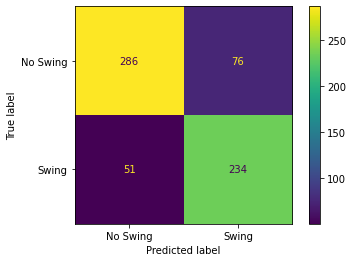

In [16]:
# Confusion Matrix
plot_confusion_matrix(clf_svm, 
                      X_test_scaled, 
                      y_test,
                      display_labels=["No Swing", "Swing"])

Confusion Matrix를 확인해보면, 총 (286+76)개의 No Swing 데이터에 대해서 286개를 정확히 No Swing이라고 예측(79.3%)하였다. 또한, 총 (51+234)개의 Swing 데이터에 대해서 234개를 정확히 Swing이라고 예측(77.6%)하였다. 전체적으로 보면 총 (280+73+66+228)개의 데이터에 대하여 (280+228)개의 데이터를 정확하게 예측(78.5%)하였다.

In [17]:
clf_svm.score(X_train_scaled, y_train)

0.8194945848375451

In [18]:
clf_svm.score(X_test_scaled, y_test)

0.80370942812983

학습시킨 데이터에 대하여 약 83.2%의 정확도로 스윙을 예측을 할 수 있었고, 검증에 활용된 test 데이터는 약 78.5%의 정확도로 스윙을 예측하였다.

----

# Swing Probability Visualization

In [19]:
# mlb 데이터 준비
mlb_21['count'] = mlb_21['balls'].astype('str')+'-'+mlb_21['strikes'].astype('str')

In [20]:
# 데이터 정리
test_data = mlb_21[['count', 'pitch_name', 'plate_x', 'plate_z', 'release_speed', 'pfx_x', 'pfx_z', 'strikes', 'balls', 'p_throws']]

In [21]:
# 더미 생성 및 missing data 처리
test_data_encoded = pd.get_dummies(test_data, columns=['p_throws'])
test_data_encoded = test_data_encoded.dropna()

### Ex1) 0-0카운트 포심에 대한 스윙 확률

In [22]:
# SVM으로 스윙 확률 계산
ff_00 = test_data_encoded[(test_data_encoded['count']=='0-0') & (test_data_encoded['pitch_name']=='4-Seam Fastball')]
ff_00_data = ff_00.drop(['count', 'pitch_name'], axis=1).copy()

ff_00_data_scaled = scaler.transform(ff_00_data)

ff_00_data['swing_prob'] = clf_svm.predict_proba(ff_00_data_scaled)[:, 1]

In [24]:
# 오타니의 실제 스윙 여부
true_ohtani = ohtani.copy()
true_ohtani['count'] = true_ohtani['balls'].astype('str')+'-'+true_ohtani['strikes'].astype('str')
true_ohtani['swing'] = np.where(true_ohtani['swing']==1, 'Swing', 'No Swing')
ff_00_true = true_ohtani[(true_ohtani['count']=='0-0')&(true_ohtani['pitch_name']=='4-Seam Fastball')]

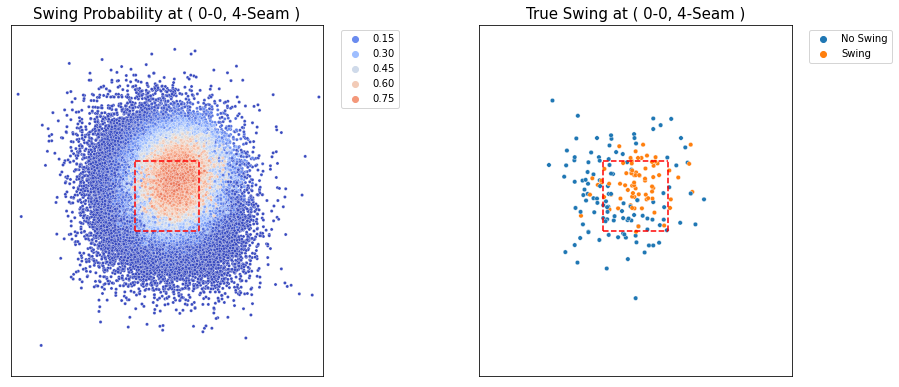

In [25]:
# 시각화
strike_x_min=-0.83
strike_x_max=0.83
strike_y_min=1.72
strike_y_max=3.51

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,8))
plt.subplots_adjust(wspace=0.5)

sns.scatterplot(ax=ax1, data=ff_00_data, x='plate_x', y='plate_z', hue='swing_prob', palette='coolwarm', hue_norm=(0,1), s=10)
ax1.vlines([strike_x_min, strike_x_max], strike_y_min, strike_y_max, colors='red', linestyles='--')
ax1.hlines([strike_y_min, strike_y_max], strike_x_min, strike_x_max, linestyles='--', colors='red')
ax1.set_xlim(-4,4)
ax1.set_ylim(-2,7)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax1.set_title("Swing Probability at ( 0-0, 4-Seam )", size=15)
ax1.set_aspect('equal')

sns.scatterplot(ax=ax2, data=ff_00_true, x='plate_x', y='plate_z', hue='swing',hue_order=['No Swing', 'Swing'], s=20)
ax2.vlines([strike_x_min, strike_x_max], strike_y_min, strike_y_max, colors='red', linestyles='--')
ax2.hlines([strike_y_min, strike_y_max], strike_x_min, strike_x_max, linestyles='--', colors='red')
ax2.set_xlim(-4,4)
ax2.set_ylim(-2,7)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax2.set_title("True Swing at ( 0-0, 4-Seam )", size=15)
ax2.set_aspect('equal')

plt.show()

### Ex2) 0-0카운트, 포심 이후 슬라이더에 대한 스윙 확률

In [26]:
sl_02_after_ff = test_data_encoded[(test_data_encoded['count']=='0-2') & 
                          (test_data_encoded['pitch_name']=='Slider')]
sl_02_data_after_ff = sl_02_after_ff.drop(['count', 'pitch_name'], axis=1).copy()
sl_02_data_after_ff

sl_02_data_scaled = scaler.transform(sl_02_data_after_ff)
sl_02_data_after_ff['swing_prob'] = clf_svm.predict_proba(sl_02_data_scaled)[:, 1]

sl_02_after_ff_true = true_ohtani[(true_ohtani['count']=='0-2')&
                                     (true_ohtani['pitch_name']=='Slider')]

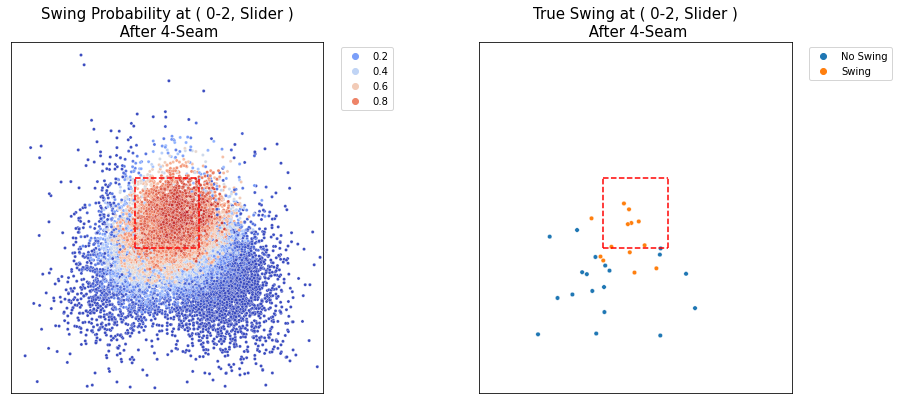

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,8))
plt.subplots_adjust(wspace=0.5)

sns.scatterplot(ax=ax1, data=sl_02_data_after_ff, x='plate_x', y='plate_z', hue='swing_prob', palette='coolwarm', hue_norm=(0,1), s=10)
ax1.vlines([strike_x_min, strike_x_max], strike_y_min, strike_y_max, colors='red', linestyles='--')
ax1.hlines([strike_y_min, strike_y_max], strike_x_min, strike_x_max, linestyles='--', colors='red')
ax1.set_xlim(-4,4)
ax1.set_ylim(-2,7)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax1.set_title("Swing Probability at ( 0-2, Slider )\n After 4-Seam", size=15)
ax1.set_aspect('equal')

sns.scatterplot(ax=ax2, data=sl_02_after_ff_true, x='plate_x', y='plate_z', hue='swing', hue_order=['No Swing', 'Swing'], s=20)
ax2.vlines([strike_x_min, strike_x_max], strike_y_min, strike_y_max, colors='red', linestyles='--')
ax2.hlines([strike_y_min, strike_y_max], strike_x_min, strike_x_max, linestyles='--', colors='red')
ax2.set_xlim(-4,4)
ax2.set_ylim(-2,7)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax2.set_title("True Swing at ( 0-2, Slider )\n After 4-Seam", size=15)
ax2.set_aspect('equal')

plt.show()

### Ex3) 3-0카운트, 포심 이후 포심에 대한 스윙 확률

In [29]:
ff_30_after_ff = test_data_encoded[(test_data_encoded['count']=='3-0') & 
                          (test_data_encoded['pitch_name']=='4-Seam Fastball')]
ff_30_data_after_ff = ff_30_after_ff.drop(['count', 'pitch_name'], axis=1).copy()
ff_30_data_after_ff

ff_30_data_scaled = scaler.transform(ff_30_data_after_ff)
ff_30_data_after_ff['swing_prob'] = clf_svm.predict_proba(ff_30_data_scaled)[:, 1]

ff_30_after_ff_true = true_ohtani[(true_ohtani['count']=='3-0')&
                                     (true_ohtani['pitch_name']=='4-Seam Fastball')]

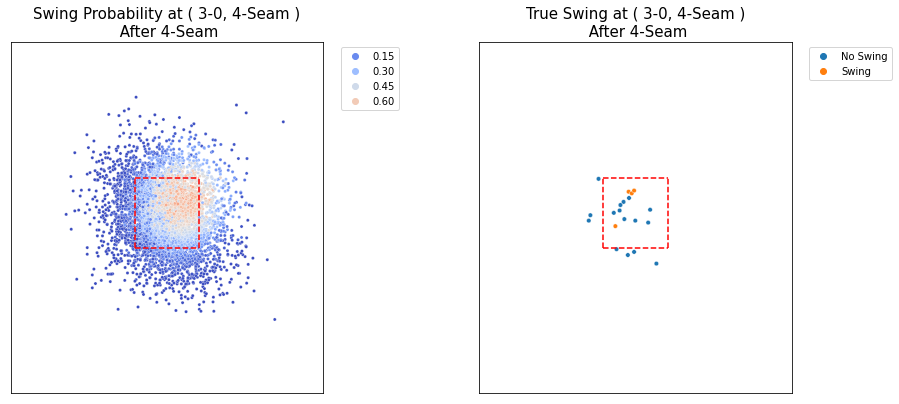

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,8))
plt.subplots_adjust(wspace=0.5)

sns.scatterplot(ax=ax1, data=ff_30_data_after_ff, x='plate_x', y='plate_z', hue='swing_prob', palette='coolwarm', hue_norm=(0,1), s=10)
ax1.vlines([strike_x_min, strike_x_max], strike_y_min, strike_y_max, colors='red', linestyles='--')
ax1.hlines([strike_y_min, strike_y_max], strike_x_min, strike_x_max, linestyles='--', colors='red')
ax1.set_xlim(-4,4)
ax1.set_ylim(-2,7)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax1.set_title("Swing Probability at ( 3-0, 4-Seam )\n After 4-Seam", size=15)
ax1.set_aspect('equal')

sns.scatterplot(ax=ax2, data=ff_30_after_ff_true, x='plate_x', y='plate_z', hue='swing', hue_order=['No Swing', 'Swing'], s=20)
ax2.vlines([strike_x_min, strike_x_max], strike_y_min, strike_y_max, colors='red', linestyles='--')
ax2.hlines([strike_y_min, strike_y_max], strike_x_min, strike_x_max, linestyles='--', colors='red')
ax2.set_xlim(-4,4)
ax2.set_ylim(-2,7)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax2.set_title("True Swing at ( 3-0, 4-Seam )\n After 4-Seam", size=15)
ax2.set_aspect('equal')

plt.show()